# Tutorial 6.2: Dynamics of a Decision-Making Circuit in Two Modes of Operation
## Neuroscience goals: 
- see how noise can lead to significant trial-to-trial variability in behavior
- compare the behavior of an integrator circuit with state-transition circuit
## Computational goals:
- simulate coupled firing-rate units with different types of noise
- record event times and realign vectors with different event times and pad them for further analysis

### Overview
- will produce decision-making circuit and study response to inputs
    - circuit will contain two units (*i*=1, 2)
    - when one of the units reaches decision-threshold, assume one of two alternatives has been chosen
- will switch mode of decision making by altering connection strengths and thresholds of the units
- firing-rate curve of units must be linear function of inputs to be perfect integrator

    $\tau\frac{dr_i}{dt} = -r_i + I_i - \Theta$

    - with constraint $0 \le r_i \le r_{max}$
    - $\Theta$ is firing-threshold (not decision threshold)
    - $I_i$ is input to unit $i$ given by:

        $I_i(t) = W_s \cdot r_i(t) + W_x \cdot r_j(t) + G\cdot s_i(t) + \sigma_{int} \cdot \eta_i (t) $

        - where $r_j(t)$ is rate of other cell (so if i=1, then j=2 and if i=2, then j=1)

    - each unit will receive independent internal noise of strength $\sigma_{int}$
    - and a scalable independent noise within the stimulus $s_i(t)$ of strength $\sigma_s$

- speed-accuracy tradeoff is achieved by altering $G$, which scales input sunapses to circuit
    - stimuli, when present, are given by 
    
        $s_1(t) = \bar s + \Delta s / 2 + \sigma_s \cdot \eta'_1 (t)$ 
        and
        $s_2(t) = \bar s - \Delta s / 2 + \sigma_s \cdot \eta'_2 (t)$ 

        with mean $\bar s = 1$ and variable difference $\Delta s$

    - terms $\eta_1(t), \eta_2(t), \eta'_1(t), \eta'_2(t)$ each represent unit variance noise to be generated independently on each trial

- for integration mode: 
    - $W_s = 0.975, W_x = -0.025, \Theta = -0.5$ for each unit

- for jumping mode:
    - $W_s = 1.05, W_x = -0.05, \Theta = 4 $ for each unit

- for both circuits, set decision threshold of 50 Hz and $r_{max} = 60$ Hz

- in all simulations, simulate until threshold is reached by one of the units or max time of 10s is reached
- use time constant $\tau = 10ms$

### Answer all questions with integration mode, then repeat all with jumping omde






### 1. simulate a single trial without noise:
- initialize firing rates of two units to their identical steady state value in the absence of a stimulus/noise by solving for $r$ in

    $\tau \frac{dr}{dt} = -r + W_s \cdot r + W_x\cdot r - \Theta = 0$

    - enforcing bounds on the range of allowed values of $r$

- in integration mode: G=1
- in jumping mode: G=2.5

In [317]:
import numpy as np
import matplotlib.pyplot as plt

In [318]:
decision_thresh = 50
r_max = 60
tau = 10e-3

params_integration = {
    'ws': 0.975,
    'wx': -0.025,
    'theta': -0.5
    }

params_jumping = {
    'ws': 1.05,
    'wx': -0.05,
    'theta': 4
    }

# calculate firing rate
def dr_dt(r, input, theta, tau=tau):
    return (-r + input - theta) / tau

# calculate input 
def get_input(ws, wx, ri, rj, G, si, sigma_int, eta):
    return ws*ri + wx*rj + G*si + ((sigma_int*eta)/np.sqrt(0.002))

# steady state firing with no inputs/noise
def get_steady_state_r(theta, ws, wx):
    r_steady = theta / (1 - ws - wx)
    return np.clip(r_steady, 0, r_max)

r_steady_int = get_steady_state_r(params_integration['theta'], params_integration['ws'], params_integration['wx'])
r_steady_jump = get_steady_state_r(params_jumping['theta'], params_jumping['ws'], params_jumping['wx'])

g_int = 1
g_jump = 2.5

### 1b
- set $\Delta s$ = 0.1 for stimulus commencing at 0.5s and remining on
- simulate differential equations with a timestep of 0.5ms
- plot firing rate of both units as function of time
- separately plot difference in firing rates

In [319]:
dt = 1e-3
t = np.arange(0, 10, dt)
stim_start = 0.5
delta_s = 0.1

s1 = np.zeros_like(t)
s2 = np.zeros_like(t)
s1[t >= stim_start] = 1 + delta_s / 2
s2[t >= stim_start] = 1 - delta_s / 2
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)

In [320]:
def run_trial(params, G, r1, r2, s1, s2, t, dt, sigma_int=0):

    theta = params['theta']
    ws = params['ws']
    wx = params['wx']

    # initialize firing rates
    r_steady = get_steady_state_r(theta, ws, wx)
    r1[0] = r_steady
    r2[0] = r_steady

    for i in range(1, len(t)):
        if i % 2 != 0:
            # get noise
            eta1 = np.random.normal(0, 1)
            eta2 = np.random.normal(0, 1)
        

        # get input for each unit
        input1 = get_input(ws, wx, r1[i - 1], r2[i - 1], G, s1[i - 1], sigma_int, eta1)
        input2 = get_input(ws, wx, r2[i - 1], r1[i - 1], G, s2[i - 1], sigma_int, eta2)

        # update firing rate for each
        r1[i] = r1[i - 1] + dt * dr_dt(r1[i - 1], input1, theta)
        r2[i] = r2[i - 1] + dt * dr_dt(r2[i - 1], input2, theta)

        # enforce bounds
        r1[i] = np.clip(r1[i], 0, r_max)
        r2[i] = np.clip(r2[i], 0, r_max)

        if r1[i] >= decision_thresh or r2[i] >= decision_thresh:
            break
    
    return r1, r2

### as integrator

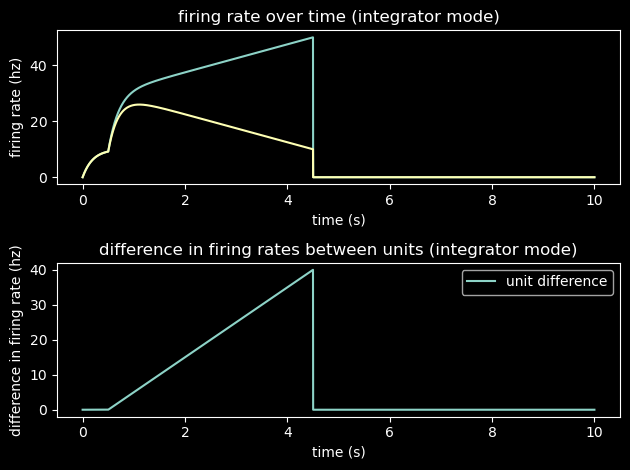

In [321]:
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)
r1_int, r2_int = run_trial(params_integration, g_int, r1, r2, s1, s2, t, dt)

plt.subplot(2, 1, 1)
plt.plot(t, r1_int, label='unit 1')
plt.plot(t, r2_int, label='unit 2')
plt.xlabel('time (s)')
plt.ylabel('firing rate (hz)')
plt.title('firing rate over time (integrator mode)')

plt.subplot(2, 1, 2)
plt.plot(t, r1_int - r2_int, label='unit difference')
plt.xlabel('time (s)')
plt.ylabel('difference in firing rate (hz)')
plt.title('difference in firing rates between units (integrator mode)')
plt.legend()
plt.tight_layout()

### as jumper

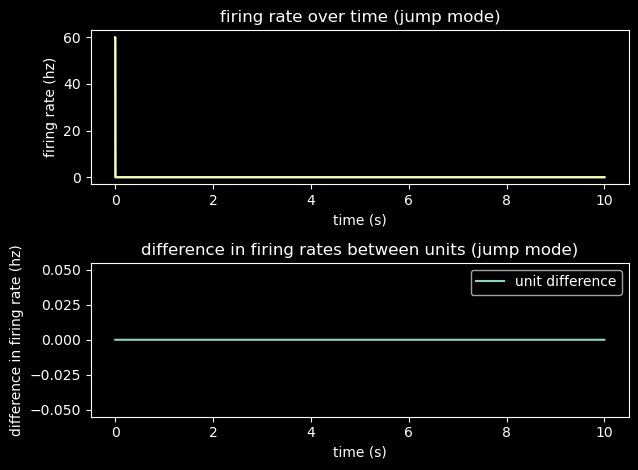

In [322]:
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)
r1_jump, r2_jump = run_trial(params_jumping, g_jump, r1, r2, s1, s2, t, 1e-3)

plt.subplot(2, 1, 1)
plt.plot(t, r1_jump, label='unit 1')
plt.plot(t, r2_jump, label='unit 2')
plt.xlabel('time (s)')
plt.ylabel('firing rate (hz)')
plt.title('firing rate over time (jump mode)')

plt.subplot(2, 1, 2)
plt.plot(t, r1_jump - r2_jump, label='unit difference')
plt.xlabel('time (s)')
plt.ylabel('difference in firing rate (hz)')
plt.title('difference in firing rates between units (jump mode)')
plt.legend()
plt.tight_layout()

### 2. add noise
- add independent noise to the entire duration of each stimulus
    - repeatedly choose two random numbers (one for each stimulus) from unit gaussian distribution (randn() in matlab)
    - keep noise values fixed for each 2ms of the stimulus duration
- multiply each noise value by $\sigma_s$ = 0.2 and divide by `np.sqrt(0.002)` before adding to stimulus
- add intrinsic noise in a similar manner, keeping fixed every 2ms, and use magnitude $\sigma_s$ = 0.25
    - ensure intrinsic noise is present across all of the time stimulated (not just during stimulus)
- simulate 200 trials, and for each trial record firing rate as function of time

In [323]:
# add noise
noise1 = np.zeros_like(t)
noise2 = np.zeros_like(t)
for i in range(len(t)):
    if i % 2 == 0:
        noise1[i] = np.random.normal(0, 1)
        noise2[i] = np.random.normal(0, 1)
    else: 
        noise1[i] = noise1[i - 1]
        noise2[i] = noise2[i - 1]

### as integrator

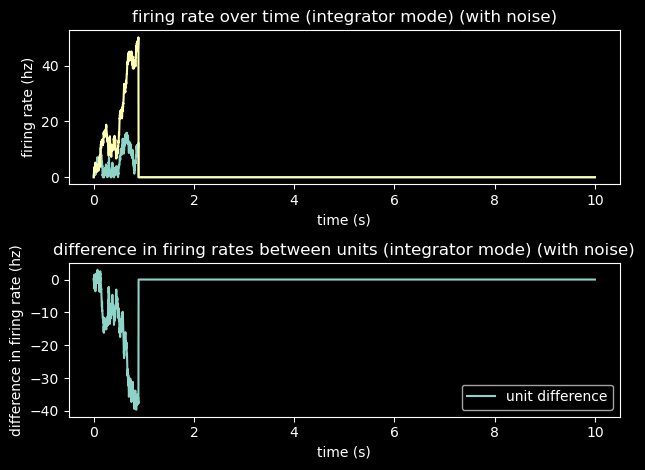

In [324]:
r1 = np.zeros_like(t)
r2 = np.zeros_like(t)
r1_int, r2_int = run_trial(params_integration, g_int, r1, r2, s1, s2, t, 1e-3, sigma_int=0.2)


plt.subplot(2, 1, 1)
plt.plot(t, r1_int, label='unit 1')
plt.plot(t, r2_int, label='unit 2')
plt.xlabel('time (s)')
plt.ylabel('firing rate (hz)')
plt.title('firing rate over time (integrator mode) (with noise)')

plt.subplot(2, 1, 2)
plt.plot(t, r1_int - r2_int, label='unit difference')
plt.xlabel('time (s)')
plt.ylabel('difference in firing rate (hz)')
plt.title('difference in firing rates between units (integrator mode) (with noise)')
plt.legend()
plt.tight_layout()

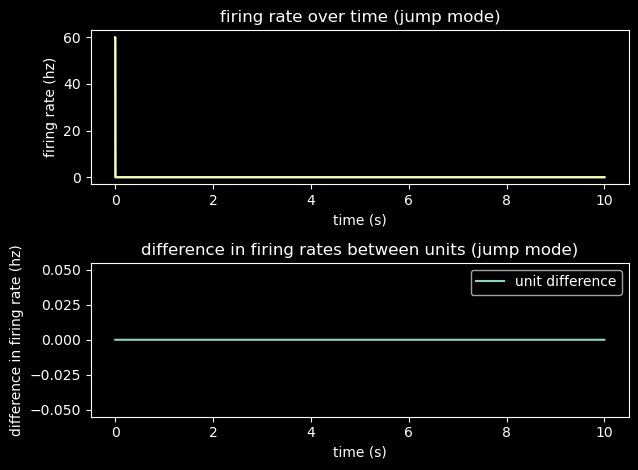

In [325]:
plt.subplot(2, 1, 1)
plt.plot(t, r1_jump, label='unit 1')
plt.plot(t, r2_jump, label='unit 2')
plt.xlabel('time (s)')
plt.ylabel('firing rate (hz)')
plt.title('firing rate over time (jump mode)')

plt.subplot(2, 1, 2)
plt.plot(t, r1_jump - r2_jump, label='unit difference')
plt.xlabel('time (s)')
plt.ylabel('difference in firing rate (hz)')
plt.title('difference in firing rates between units (jump mode)')
plt.legend()
plt.tight_layout()